# Practical Data Science
## Predicting customer churn

"Churn Rate" is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive).

In this practical notebook I will go through the process of gathering and manipulating the dataset to then build a predictive model to predict churn. Predicting churn is particularly important for businesses w/ subscription models such as cell phone, cable, or merchant credit card processing plans. But modeling churn has wide reaching applications in many domains. For example, casinos have used predictive models to predict ideal room conditions for keeping patrons at the blackjack table and when to reward unlucky gamblers with front row seats to Celine Dion. Similarly, airlines may offer first class upgrades to complaining customers. The list goes on.

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline

## Dataset

The dataset is a longstanding telecom customer data set. Each row represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

In [4]:
churn_df = pd.read_csv('data/telecom.csv')
col_names = churn_df.columns.tolist()

print('Column names:')
print(col_names)

to_show = col_names[:6] + col_names[-6:]

print('Sample data:')
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']
Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


Time to drop irrelevant columns and converts strings to boolean values.

In [6]:
# Isolate target data, save it to y
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# drop useless columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

# yes and no need to become boolean values
yes_no_cols = ["Int'l Plan",'VMail Plan']
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [7]:
X = churn_feat_space.as_matrix().astype(np.float)

# It's important to scale our data 
scaler = StandardScaler()
X = scaler.fit_transform(X)
print('Feature space holds %d observations and %d features' % X.shape)
print('Unique target labels:', np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


## Evaluating models

"*Express, test, cycle. A machine learning pipeline should be anything but static. There are always new features to design, new data to use, new classifiers to consider each with unique parameters to tune. And for every change it's critical to be able to ask, "Is the new version better than the last?" So how do I do that?*"

I will use Cross Validation as a starting point; Cross validation attempts to avoid overfitting (training on and predicting the same datapoint) while still producing a prediction for each observation dataset. This is accomplished by systematically hiding different subsets of the data while training a set of models. After training, each model predicts on the subset that had been hidden to it, emulating multiple train-test splits. When done correctly, every observation will have a 'fair' corresponding prediction.

In [14]:
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(n_splits=3,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Let's compare three different (fairly standard) algorithms: support vector machines, random forest, and k-nearest-neighbors.

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

In [15]:
def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print("Logistic Regression:")
print("%.3f" % accuracy(y, run_cv(X,y,LR)))
print("Gradient Boosting Classifier")
print("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print("Support vector machines:")
print("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print("Random forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Logistic Regression:
0.862
Gradient Boosting Classifier
0.948
Support vector machines:
0.918
Random forest:
0.942
K-nearest-neighbors:
0.893


It might seem like we've got a winner, but measurements are always tricky... and there's not one metric that is enough by itself to evaluate the performance of a model. It's up to the human to be able to understand how important a certain metric is and how insightful the information is. 

### Precision, recall, confusion matrix and more

A confusion matrix is a way of visualizing predictions made by a classifier and is just a table showing the distribution of predictions for a specific class. The x-axis indicates the true class of each observation (if a customer churned or not) while the y-axis corresponds to the class predicted by the model (if my classifier said a customer would churned or not).

|                  | Condition TRUE      | Condition FALSE     |
|------------------|---------------------|---------------------|
| Prediction TRUE  | True Positive (TP)  | False Positive (FP) |
| Prediction FALSE | False Negative (FN) | True Negative (TN)  |

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Support Vector Machines
[[2813   37]
 [ 247  236]]


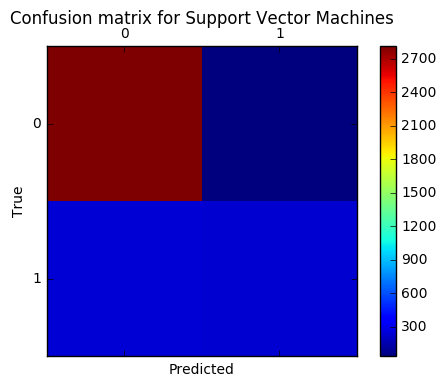

Random Forest
[[2806   44]
 [ 161  322]]


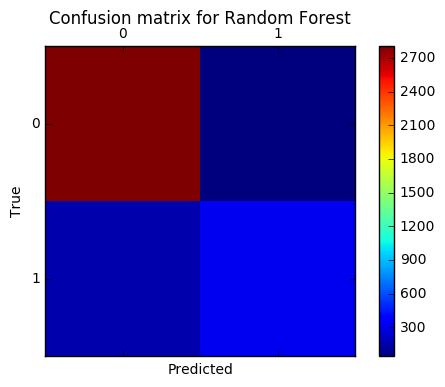

K-Nearest-Neighbors
[[2802   48]
 [ 310  173]]


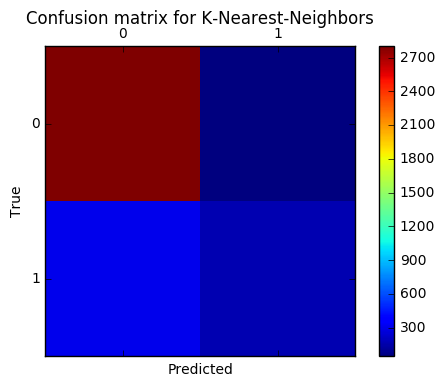

Gradient Boosting Classifier
[[2827   23]
 [ 127  356]]


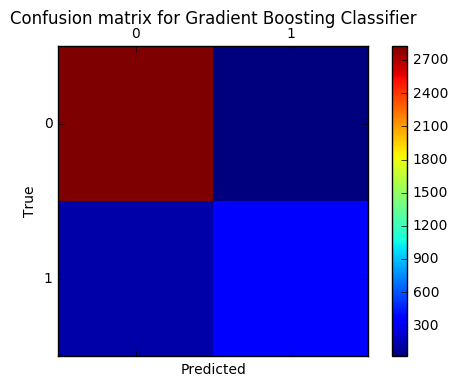

Logisitic Regression
[[2769   81]
 [ 383  100]]


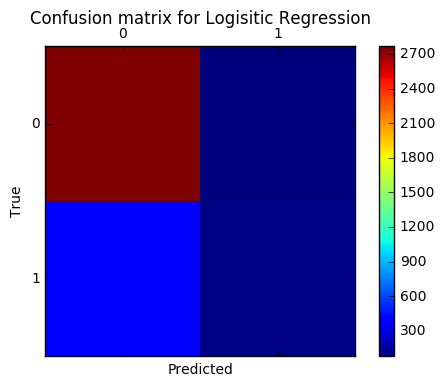

In [19]:
def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(classifier)
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

draw_confusion_matrices(confusion_matrices,class_names)

Another important metric to consider is ROC plots.

Simply put, the area under the curve (AUC) of a receiver operating characteristic (ROC) curve is a way to reduce ROC performance to a single value representing expected performance. To explain with a little more detail, a ROC curve plots the true positives (sensitivity) vs. false positives (1 − specificity), for a binary classifier system as its discrimination threshold is varied. Since a random method describes a horizontal curve through the unit interval, it has an AUC of .5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

Support vector machines:


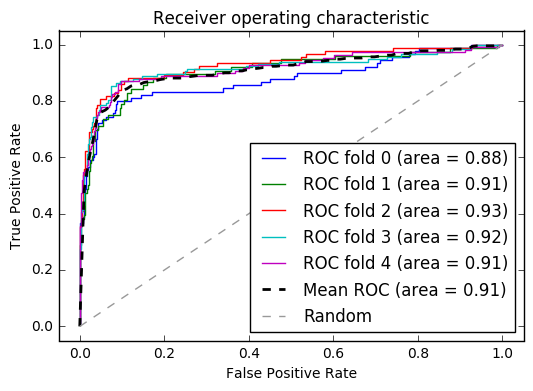

Random forests:


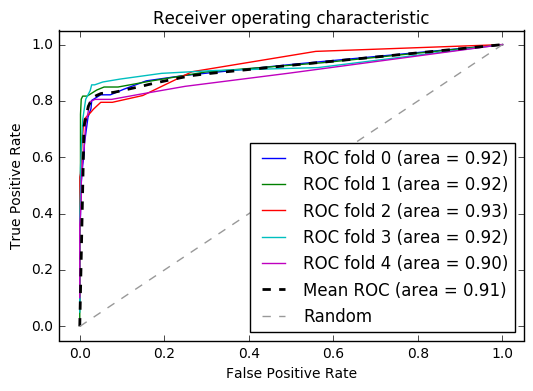

K-nearest-neighbors:


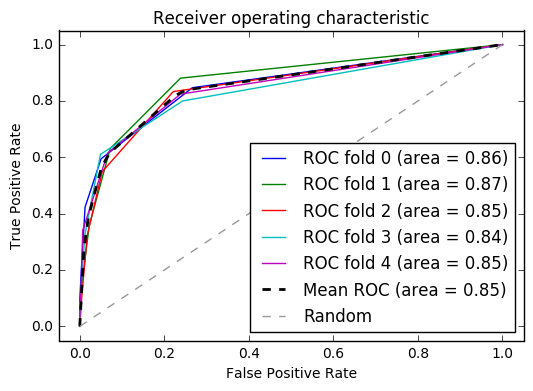

Gradient Boosting Classifier:


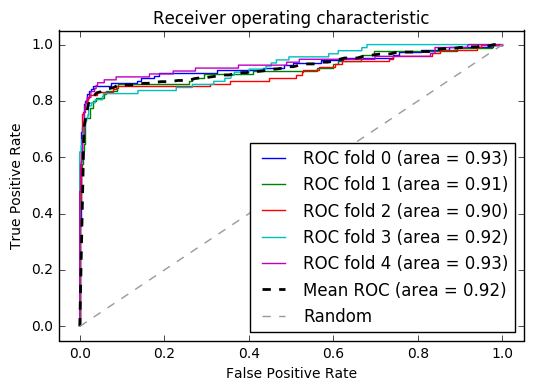

In [24]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= kf.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print("K-nearest-neighbors:")
plot_roc(X,y,KNN)

print("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

## Feature importance

It's now time to dive a little deeper to get a better understanding of what features or behaviours are causing our customers to churn. In the next section, I will be using a RandomForestClassifer to build an ensemble of decision trees to predict whether a customer will churn or not churn.

Let's first look at the Top 10 features in the dataset that contribute to customer churn.

Feature ranking:
1. Account Length (0.147736)
2. Int'l Plan (0.147634)
3. VMail Plan (0.075570)
4. VMail Message (0.073516)
5. Day Mins (0.071826)
6. Day Calls (0.037868)
7. Day Charge (0.026101)
8. Eve Mins (0.023597)
9. Eve Calls (0.021980)
10. Eve Charge (0.017155)


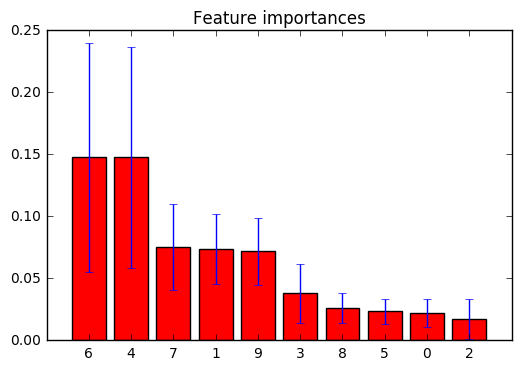

In [25]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

## Moving to probabilities

Decision making often favors probability over simple classifications. Probability predictions for churn also allow us to gauge a customers expected value, and their expected loss.

In [26]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

Determining how good a predictor which gives probabilities rather than classes is a bit more difficult. If I predict there's a 20% likelihood of rain tomorrow I don't get to live out all the possible outcomes of the universe. It either rains or it doesn't.

What helps is that the predictors aren't making one prediction, they're making 3000+. So for every time I predict an event to occur 20% of the time I can see how often those events actually happen.

In [27]:
# I use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1752
0.1     708
0.2     278
0.3     124
0.8     101
0.9      76
0.4      67
0.7      65
1.0      55
0.5      54
0.6      53
dtype: int64

In [28]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1752,0.025114
1,0.1,708,0.042373
2,0.2,278,0.025180
3,0.3,124,0.129032
4,0.4,67,0.402985
5,0.5,54,0.574074
6,0.6,53,0.830189
7,0.7,65,0.907692
8,0.8,101,0.930693
9,0.9,76,1.000000


We can see that random forests predicted that 75 individuals would have a 0.9 proability of churn and in actuality that group had a ~0.97 rate.